# ABM SIR simulation

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

from mesa.batchrunner import BatchRunner

import random
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 9, 'font.style': 'normal', 'font.family':'serif'})

In [3]:
def compute_S(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Susceptible'])

def compute_I(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Infected'])

def compute_R(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Recovered'])

In [4]:
class SIR_Agent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
        if random.random() < 0.05:
            self.health = 'Infected'
        else:
            self.health = 'Susceptible'

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

        
    def try_to_infect_neighbors(self):
        neighbors_nodes = self.model.grid.get_neighbors(self.pos,moore = True, include_center=True)
        susceptible_neighbors = [a for n in neighbors_nodes  for a in self.model.grid.get_cell_list_contents(n.pos) if a.health == 'Susceptible' ]
        
        for a in susceptible_neighbors:
            if self.random.random() < self.model.beta:
                a.health = 'Infected'
    
    def try_to_recovery(self):
        gamma = 1 / (self.model.recover)
        if random.random() < gamma:
            self.health ='Recovered'      
                    
    def step(self):
        self.move()
        if self.health == 'Infected':
            self.try_to_infect_neighbors()
            self.try_to_recovery()
            
    

class SIR_Model(Model):
    """SIR MODEL: """
    def __init__(self, N, width, height, beta, recover):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.beta = beta # rate of infection
        self.recover = recover # avg time to recover
        self.running = True
        
        # Create agents
        for i in range(self.num_agents):
            a = SIR_Agent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_I,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.tot_infected = compute_I(self) #<--- if there are no more infected, we want to stop the simulation
        if self.tot_infected == 0:
            self.running = True

##  Run the model and collect the data over one run


In [5]:
model = SIR_Model(100, 10, 10, 0.04, 7) 

while model.schedule.steps < 60:
    model.step()

RES = model.datacollector.get_model_vars_dataframe()
print('Simulation is over!')

Simulation is over!


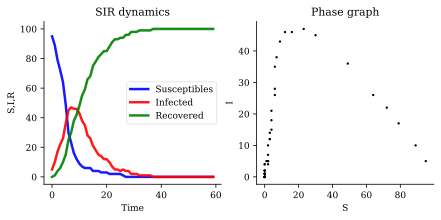

In [6]:
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(7,3))

ax = axs[0]
ax.set_title('SIR dynamics')
ax.plot(RES.index, RES.Susceptibles, 'b', alpha=0.9, lw=2.5, label= 'Susceptibles')
ax.plot(RES.index, RES.Infected, 'r', alpha=0.9, lw=2.5, label= 'Infected')
ax.plot(RES.index, RES.Recovered, 'g', alpha=0.9, lw=2.5, label= 'Recovered')
ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(RES.Susceptibles, RES.Infected ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

## INTERACTIVE VISALIZATION

In [16]:
from mesa.visualization.ModularVisualization import ModularServer #<-import the server class
from mesa.visualization.modules import CanvasGrid 
from mesa.visualization.modules import ChartModule, TextElement



def agent_portrayal(agent):
    if agent is None:
        return
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Color":"grey",
                 "Layer":0,
                 "r": 0.7}
    
    if agent.health == 'Infected':
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.4
    elif agent.health == 'Susceptible':
        portrayal["Color"] = "blue"
    
    elif agent.health == 'Recovered':
        portrayal["Color"] = "green"
        portrayal["Layer"] = 2
        portrayal["r"] = 0.15
    return portrayal



grid = CanvasGrid(agent_portrayal, 20, 20, 500, 500)

chart1 = ChartModule([{"Label": "Infected","Color": "red"},
                      {"Label": "Susceptibles","Color": "blue"},
                      {"Label": "Recovered","Color": "green"}])

server = ModularServer(SIR_Model,
                       [grid, chart1], #<-here we add components
                       "SIR Model",
                       {'N':200, 'width':20, 'height':20, 'beta':0.3, 'recover':7})

server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step